# Imports

In [2]:
import argparse
import os
import copy
import numpy as np
import PIL.Image as pil_image
from PIL import Image
import matplotlib. pyplot as plt 
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms as transforms
import time


# Model

In [4]:
class FSRCNN(nn.Module):
    def __init__(self, scale_factor):

        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')    
        # paper(filter_size, number_of_filters, number_of_channels)
        # Correspondência com os parâmetros do PyTorch:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size)
        #        number_of_chennels, number_of_filters, filter_size

        super(FSRCNN, self).__init__()
        self.scale_factor = scale_factor

        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, 56, kernel_size=5, padding=2),
            nn.PReLU()
        )
        self.shrinking = nn.Sequential(
            nn.Conv2d(56, 12, kernel_size=1),
            nn.PReLU()
        )
        self.non_linear_mapping = nn.Sequential(
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU()
        )
        self.expanding = nn.Sequential(
            nn.Conv2d(12, 56, kernel_size=1),
            nn.PReLU()
        )
        self.deconvolution = nn.ConvTranspose2d(56, 3, kernel_size=9, stride=scale_factor, padding=4, output_padding=scale_factor-1)

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.shrinking(x)
        x = self.non_linear_mapping(x)
        x = self.expanding(x)
        x = self.deconvolution(x)
        return x


# Dataloader / preprocessing

In [9]:
class DIV2KDataset(Dataset):
    def __init__(self, img_dir, scale_factor, desired_height, desired_width):
        super(DIV2KDataset, self).__init__()
        self.img_dir = img_dir
        self.scale_factor = scale_factor
        self.desired_height = desired_height
        self.desired_width = desired_width
        self.img_list = os.listdir(self.img_dir)

    def __getitem__(self, index):
        img_hr = Image.open(os.path.join(self.img_dir, self.img_list[index]))

        # Redimensionar imagem HR para o tamanho desejado
        img_hr = img_hr.resize((self.desired_width, self.desired_height), Image.BICUBIC)

        # Redimensionar imagem LR correspondente com o fator de escala
        img_lr = img_hr.resize((self.desired_width // self.scale_factor, self.desired_height // self.scale_factor), Image.BICUBIC)

        transform = transforms.Compose([
            # Aplicar transformações adicionais às imagens HR e LR, se necessário
            transforms.ToTensor(),
            # Adicione outras transformações, como normalização, se desejar
        ])

        img_hr = transform(img_hr)
        img_lr = transform(img_lr)

        return img_hr, img_lr

    def __len__(self):
        return len(self.img_list)


# Train and Val

In [4]:
class TrainFSRCNN(object):
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, n_epochs, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.n_epochs = n_epochs
        self.device = device

    def train(self):
        # Adicionar um temporizador para calcular o tempo de treinamento
        start_time = time.time()

        self.model = self.model.to(self.device)
        self.model.train()

        for epoch in range(self.n_epochs):
            running_loss = 0.0
            for i, (hr, lr) in enumerate(self.train_loader):
                hr = hr.to(self.device)
                lr = lr.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model(lr)
                loss = self.criterion(outputs, hr)

                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            # Validar no conjunto de validação
            val_loss, val_psnr = self.validate()

            # Imprimir estatísticas
            print("Epoch: %d, Loss: %.3f, Validation Loss: %.3f, Validation PSNR: %.2f" %
                  (epoch + 1, running_loss / len(self.train_loader), val_loss, val_psnr))

        # Adicionar um temporizador para calcular o tempo de treinamento
        end_time = time.time()
        total_time = end_time - start_time
        print('Tempo total de treinamento: {:.2f} segundos'.format(total_time))

    def validate(self):
        self.model.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_psnr = 0.0
            for hr, lr in self.val_loader:
                hr = hr.to(self.device)
                lr = lr.to(self.device)
                outputs = self.model(lr)
                loss = self.criterion(outputs, hr)
                val_loss += loss.item()

                # Calcular PSNR
                mse = torch.mean((hr - outputs) ** 2)
                psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
                val_psnr += psnr.item()

            return val_loss / len(self.val_loader), val_psnr / len(self.val_loader)


In [5]:
class Args:
    train_dir = 'C:/Users/moreiran/Desktop/FSRCNN2/DIV2K/DIV2K/DIV2K_train_HR/DIV2K_train_HR'
    val_dir = 'C:/Users/moreiran/Desktop/FSRCNN2/DIV2K/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR'
    scale = 4
    batch_size = 4
    epochs = 300

args = Args()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carregar dataset de treinamento
train_dataset = DIV2KDataset(args.train_dir, args.scale, 1020, 2040)

# Carregar dataset de validação
val_dataset = DIV2KDataset(args.val_dir, args.scale, 1020, 2040)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True)

model = FSRCNN(scale_factor=args.scale)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
train_fsrcnn = TrainFSRCNN(model, criterion, optimizer, train_loader, val_loader, args.epochs, device)

train_fsrcnn.train()


C:\Users\moreiran\AppData\Local\Temp\ipykernel_35864\2582354567.py:14: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img_hr = img_hr.resize((self.desired_width, self.desired_height), Image.BICUBIC)
C:\Users\moreiran\AppData\Local\Temp\ipykernel_35864\2582354567.py:17: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img_lr = img_hr.resize((self.desired_width // self.scale_factor, self.desired_height // self.scale_factor), Image.BICUBIC)


Epoch: 1, Loss: 0.217, Validation Loss: 0.193, Validation PSNR: 7.43
Epoch: 2, Loss: 0.177, Validation Loss: 0.147, Validation PSNR: 8.48
Epoch: 3, Loss: 0.101, Validation Loss: 0.056, Validation PSNR: 12.57
Epoch: 4, Loss: 0.043, Validation Loss: 0.034, Validation PSNR: 14.71
Epoch: 5, Loss: 0.032, Validation Loss: 0.029, Validation PSNR: 15.41
Epoch: 6, Loss: 0.029, Validation Loss: 0.027, Validation PSNR: 15.75
Epoch: 7, Loss: 0.027, Validation Loss: 0.025, Validation PSNR: 16.04
Epoch: 8, Loss: 0.025, Validation Loss: 0.024, Validation PSNR: 16.29
Epoch: 9, Loss: 0.024, Validation Loss: 0.023, Validation PSNR: 16.46
Epoch: 10, Loss: 0.023, Validation Loss: 0.022, Validation PSNR: 16.61
Epoch: 11, Loss: 0.023, Validation Loss: 0.022, Validation PSNR: 16.76
Epoch: 12, Loss: 0.022, Validation Loss: 0.021, Validation PSNR: 16.85
Epoch: 13, Loss: 0.022, Validation Loss: 0.021, Validation PSNR: 16.94
Epoch: 14, Loss: 0.022, Validation Loss: 0.021, Validation PSNR: 17.02
Epoch: 15, Loss: 

KeyboardInterrupt: 

# Inference

In [6]:
torch.save(model.state_dict(), '300_epochs.pt')

C:\Users\moreiran\AppData\Local\Temp\ipykernel_18996\2582354567.py:14: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img_hr = img_hr.resize((self.desired_width, self.desired_height), Image.BICUBIC)
C:\Users\moreiran\AppData\Local\Temp\ipykernel_18996\2582354567.py:17: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img_lr = img_hr.resize((self.desired_width // self.scale_factor, self.desired_height // self.scale_factor), Image.BICUBIC)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


imagem PREDITA torch.Size([3, 1020, 2040])
imagem HR torch.Size([3, 1020, 2040])


(-0.5, 2039.5, 1019.5, -0.5)

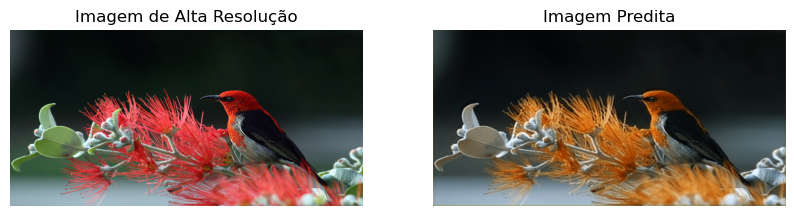

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FSRCNN(4)
model.to(device)
model.load_state_dict(torch.load('300_epochs.pt'))
model.eval()

class Args:
    train_dir = 'C:/Users/moreiran/Desktop/FSRCNN_DIV2K/DIV2K/DIV2K/DIV2K_train_HR/DIV2K_train_HR'
    val_dir = 'C:/Users/moreiran/Desktop/FSRCNN_DIV2K/DIV2K/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR'
    scale = 4
    batch_size = 4
    epochs = 300

args = Args()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carregar dataset de treinamento
train_dataset = DIV2KDataset(args.train_dir, args.scale, 1020, 2040)

# Carregar dataset de validação
val_dataset = DIV2KDataset(args.val_dir, args.scale, 1020, 2040)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True)

# hr_img, lr_img
x_batch, y_batch = next(iter(val_loader))
y, x = x_batch[0], y_batch[0]
x = x.to(device)
pred = model(x)
pred = pred.cpu()
print('imagem PREDITA', pred.shape)
print('imagem HR', y.shape)

# Converter tensores para arrays numpy
y = y.numpy().transpose(1, 2, 0)
pred = pred.detach().numpy().transpose(1, 2, 0)

# Plotar as imagens
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(y)
axes[0].set_title('Imagem de Alta Resolução')
axes[0].axis('off')

axes[1].imshow(pred)
axes[1].set_title('Imagem Predita')
axes[1].axis('off')


C:\Users\moreiran\AppData\Local\Temp\ipykernel_35864\2582354567.py:14: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img_hr = img_hr.resize((self.desired_width, self.desired_height), Image.BICUBIC)
C:\Users\moreiran\AppData\Local\Temp\ipykernel_35864\2582354567.py:17: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img_lr = img_hr.resize((self.desired_width // self.scale_factor, self.desired_height // self.scale_factor), Image.BICUBIC)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


imagem PREDITA torch.Size([3, 1020, 2040])
imagem HR torch.Size([3, 1020, 2040])


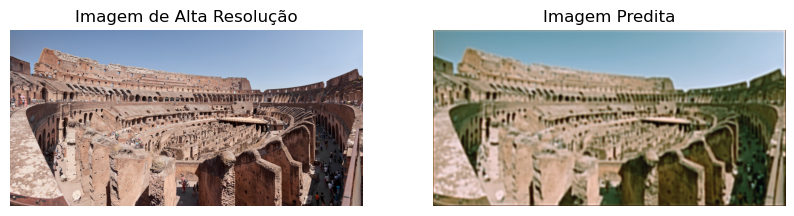

In [16]:
# hr_img, lr_img
x_batch, y_batch = next(iter(val_loader))
y, x = x_batch[0], y_batch[0]
x = x.to(device)
pred = model(x)
pred = pred.cpu()
print('imagem PREDITA', pred.shape)
print('imagem HR', y.shape)

# Converter tensores para arrays numpy
y = y.numpy().transpose(1, 2, 0)
pred = pred.detach().numpy().transpose(1, 2, 0)

# Plotar as imagens
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(y)
axes[0].set_title('Imagem de Alta Resolução')
axes[0].axis('off')

axes[1].imshow(pred)
axes[1].set_title('Imagem Predita')
axes[1].axis('off')

plt.show()


In [15]:
# # O MSE calcula a média dos erros ao quadrado entre os pixels das duas imagens. Quanto menor o valor do MSE, menor é a diferença entre as imagens.
# # O SSIM compara a estrutura e a semelhança entre as duas imagens. O valor do SSIM varia de -1 a 1, onde 1 indica uma correspondência perfeita entre as imagens.

# from skimage.metrics import mean_squared_error, structural_similarity

# # Converter as imagens para escala de 0 a 255 (uint8)
# y = (y * 255).astype('uint8')
# pred = (pred * 255).astype('uint8')

# # Calcular o MSE
# mse = mean_squared_error(y, pred)
# print(f"MSE: {mse}")

# # Calcular o SSIM
# ssim = structural_similarity(y, pred, multichannel=True)
# print(f"SSIM: {ssim}")


MSE: 425.810462161989


C:\Users\moreiran\AppData\Local\Temp\ipykernel_35864\3722313852.py:15: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(y, pred, multichannel=True)


SSIM: 0.5997074890040669


# HR and LR image comparasion

C:\Users\moreiran\AppData\Local\Temp\ipykernel_35864\2582354567.py:14: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img_hr = img_hr.resize((self.desired_width, self.desired_height), Image.BICUBIC)
C:\Users\moreiran\AppData\Local\Temp\ipykernel_35864\2582354567.py:17: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img_lr = img_hr.resize((self.desired_width // self.scale_factor, self.desired_height // self.scale_factor), Image.BICUBIC)


imagem HR torch.Size([1020, 2040, 3])
imagem LR torch.Size([255, 510, 3])


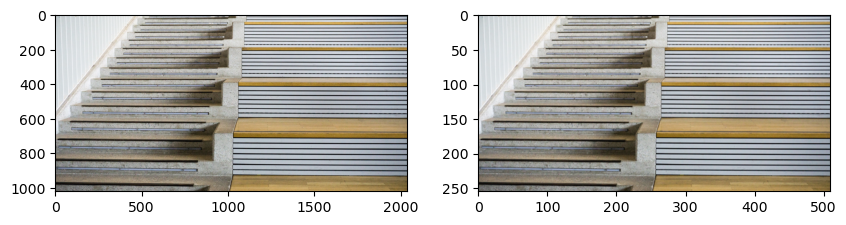

In [14]:
def train_imgs_visualization():
    for imgs in train_loader:
        fig = plt.figure(figsize=(10, 7))

        img1 = imgs[0][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 1)
        plt.imshow(img1)
        print('imagem HR', img1.shape)

        
        img2 = imgs[1][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 2)
        plt.imshow(img2)
        print('imagem LR', img2.shape)
        break

def val_imgs_visualization():
    for imgs in val_loader:
        fig = plt.figure(figsize=(10, 7))

        img1 = imgs[0][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 1)
        plt.imshow(img1)
        
        img2 = imgs[1][0].permute(1, 2, 0)
        fig.add_subplot(1, 2, 2)
        plt.imshow(img2)
        break

train_imgs_visualization()